# Variational Bayes
Since there were some problems with some models and finding latent variables and parameters through variational Bayes methods, they are tested here.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from sklearn import datasets
import os
import pickle
from utils import loadStan, est_k, hierarchical_model
import scipy
import sklearn
from sklearn.cluster import SpectralClustering
from scipy.stats import norm,multivariate_normal
from sklearn.metrics import adjusted_rand_score,accuracy_score
import pandas as pd
sns.set()

ppca_model = loadStan('ppca')
gmm_model = loadStan('gmm')
gmm_diag = loadStan('gmm_diag')
moppcas_model = loadStan('moppcas')
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')
gmm_weighted = loadStan('gmm_weighted')

Loading model  ppca
Model loaded succesfully from cache.
Loading model  gmm
Model loaded succesfully from cache.
Loading model  gmm_diag
Model loaded succesfully from cache.
Loading model  moppcas
Model loaded succesfully from cache.
Loading model  moppcas_weighted
Model loaded succesfully from cache.
Loading model  ppca_weighted
Model loaded succesfully from cache.
Loading model  gmm_weighted
Model loaded succesfully from cache.


## PPCA
(works correctly, both with NUTS and VB)

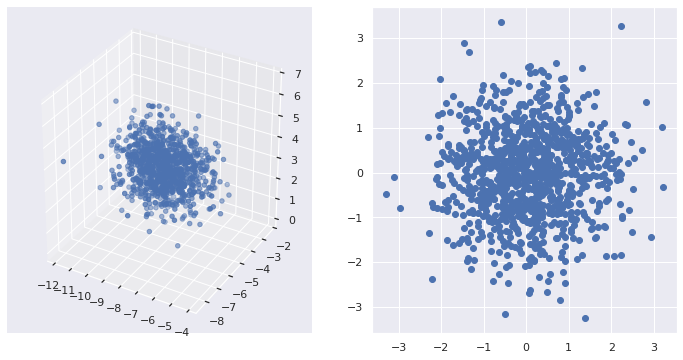

In [7]:
N=1000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
W = np.random.normal(0,sigma,size=(D,M))
mu = np.random.normal(0,10,size=D)[np.newaxis].T
x = np.random.normal(np.matmul(W,z),sigma)+mu
    
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x[0,:], x[1,:], x[2,:])
ax = fig.add_subplot(122)
ax.scatter(z[0,:], z[1,:])
plt.show()
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}

In [8]:
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}
ppca_data = ppca_model.vb(data = ppca_dat)

In [12]:
ppca_df = pd.read_csv(ppca_data['args']['sample_file'].decode('ascii'), comment='#').dropna()
ppca_df_mean = ppca_df.mean()
best_sample = ppca_df.iloc[np.argmax(ppca_df['log_p__'][1:])+1]
z_vb = np.reshape(np.array(best_sample[best_sample.index.str.startswith('z')]),(N,M)).T
mu_vb = np.array(ppca_df_mean[ppca_df_mean.index.str.startswith('mu')])[np.newaxis].T
W_vb = np.reshape(np.array(ppca_df_mean[ppca_df_mean.index.str.startswith('W')]),(M,D)).T
sigma_vb = ppca_df_mean[ppca_df_mean.index.str.startswith('sigma')]

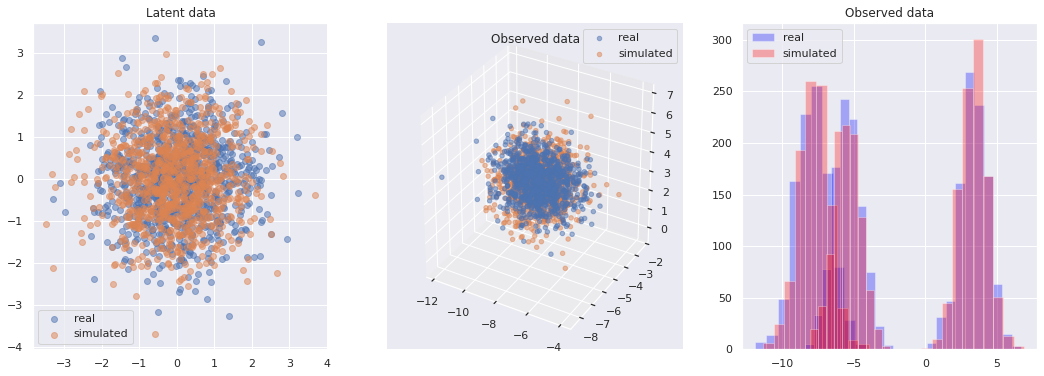

In [101]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(131)
ax.scatter(z[0,:], z[1,:], alpha=0.5, label='real')
ax.scatter(z_vb[0,:], z_vb[1,:], alpha=0.5, label='simulated')
ax.set_title('Latent data')
ax.legend()
ax = fig.add_subplot(132, projection='3d')
ax.scatter(x[0,:], x[1,:], x[2,:], alpha=0.5, label='real')
ax.scatter(rec_x[0,:], rec_x[1,:], rec_x[2,:], alpha=0.5, label='simulated')
ax.set_title('Observed data')
ax.legend()
ax = fig.add_subplot(133)
ax.hist(x[0,:], alpha=0.3, color='blue', label='real')
ax.hist(x[1,:], alpha=0.3, color='blue')
ax.hist(x[2,:], alpha=0.3, color='blue')
ax.hist(rec_x[0,:], alpha=0.3, color='red', label='simulated')
ax.hist(rec_x[1,:], alpha=0.3, color='red')
ax.hist(rec_x[2,:], alpha=0.3, color='red')
ax.legend()
ax.set_title('Observed data')
plt.show()


## Gaussian Mixture Model
(works now with VB and NUTS)

In [86]:
gmm_diag = loadStan('gmm_diag', recompile=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_51fdda3201ef7c1e4dc921c3f8c7e918 NOW.


Model compiled succesfully.
Model saved succesfully to cache.


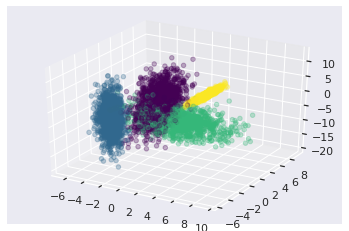

In [63]:
N=5000
K=4
D=3
y_gmm = []
z_gmm = []
ind = []
mu = np.random.normal(0,3,size=(K,D))
# sigmas = [np.random.uniform(0,5, size=D) for i in range(K)]
# covariance = [np.diag(sigmas[k]) for k in range(K)]

sigmas = [np.random.lognormal(0,1, size=D) for i in range(K)]
# covs = [np.diag(sigmas[k]) for k in range(K)]

while True:      # make sure to not have a negligible cluster
    theta = np.random.dirichlet(np.ones(K))
    if np.all(theta>(1.0/(2*K))):
        break
        
for i in range(N):
    opt = np.random.choice(list(range(K)),p=theta)
    z_gmm.append(opt)
    y_gmm.append(np.random.normal(mu[opt],sigmas[opt]))
    ind.append(opt)
y_gmm = np.array(y_gmm)
ind = np.array(ind)
sns.set()

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(y_gmm[:,0], y_gmm[:,1], y_gmm[:,2], c=z_gmm, cmap='viridis', alpha=0.3)
plt.show()

sample_theta = []
sample_sigma = []
sample_mu = []

for k in range(K):
    sample_theta.append(len(y_gmm[np.array(z_gmm)==k])/N)
    sample_mu.append(list(np.mean(y_gmm[np.array(z_gmm)==k], axis=0)))
    sample_sigma.append(np.std(y_gmm[np.array(z_gmm)==k].T,axis=1))

### VB

In [87]:
kmeans_init = KMeans(K).fit(y_gmm)
gmm_dat = {'N': N,'K': K, 'D':D, 'y':y_gmm}

In [88]:
gmm_data = gmm_diag.vb(data=gmm_dat, verbose = True, init=[{'mu':kmeans_init.cluster_centers_}])
#                                             'theta': [sum(kmeans_init.labels_==k) for k in range(K)],
#                                            'sigma':[np.std(y_gmm[kmeans_init.labels_==k],axis=0) for k in range(K)]}])

In [90]:
gmm_df = pd.read_csv(gmm_data['args']['sample_file'].decode('ascii'), comment='#').dropna()
gmm_df_mean = gmm_df.mean()
best_sample = gmm_df.iloc[np.argmax(gmm_df['log_p__'][1:])+1]
mu_vb = np.reshape(np.array(gmm_df_mean[gmm_df_mean.index.str.startswith('mu')]),(D,K)).T
sigma_vb = np.reshape(np.array(gmm_df_mean[gmm_df_mean.index.str.startswith('sigma')]),(D,K)).T
theta_vb = np.array(gmm_df_mean[gmm_df_mean.index.str.startswith('theta')])
theta_vb = theta_vb/sum(theta_vb)
z_vb = np.reshape(np.array(gmm_df_mean[gmm_df_mean.index.str.startswith('z')]),(K,N)).T
ind_vb = np.argmax(z_vb, axis=1)

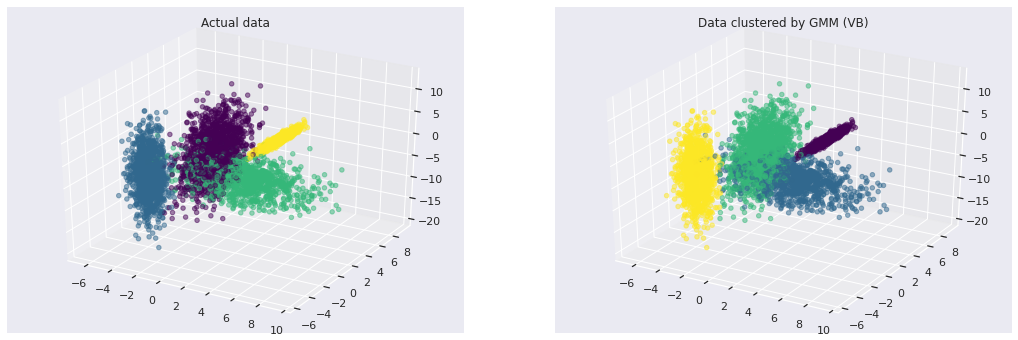

In [91]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(y_gmm[:,0], y_gmm[:,1], y_gmm[:,2], alpha=0.5, c = ind, cmap='viridis')
ax.set_title('Actual data')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(y_gmm[:,0], y_gmm[:,1], y_gmm[:,2], alpha=0.5, c = ind_vb, cmap='viridis')
ax.scatter(mu_vb[:,0], mu_vb[:,1], mu_vb[:,2], alpha=0.5, c = 'red')
ax.set_title('Data clustered by GMM (VB)')
plt.show()


In [92]:
rec_ind_vb = list()
y_vb = list()
for i in range(N):
    opt = np.random.choice(list(range(K)),p=theta_vb)
    rec_ind_vb.append(opt)
    y_vb.append(np.random.multivariate_normal(mu_vb[opt],np.diag(sigma_vb[opt])))
y_vb = np.array(y_vb)
rec_ind_vb = np.array(rec_ind_vb)

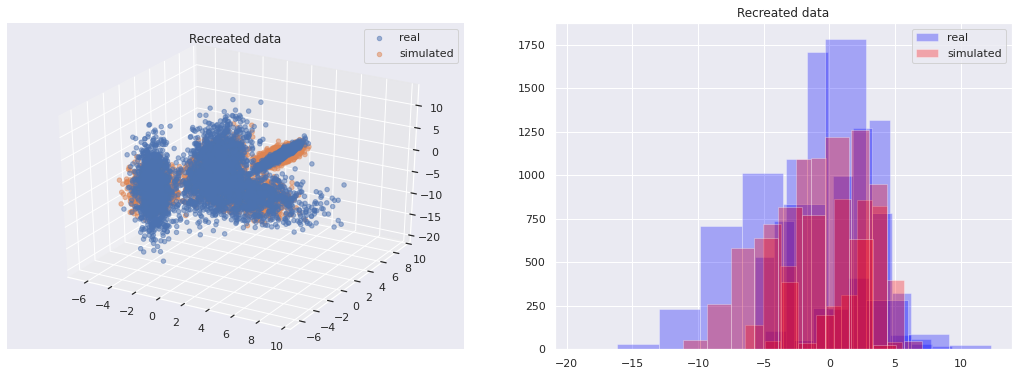

In [93]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(y_gmm[:,0], y_gmm[:,1], y_gmm[:,2], alpha=0.5, label='real')
ax.scatter(y_vb[:,0], y_vb[:,1], y_vb[:,2], alpha=0.5, label='simulated')#, c = rec_ind_vb, cmap='viridis')
ax.set_title('Recreated data')
ax.legend()
ax = fig.add_subplot(122)
ax.hist(y_gmm[:,0], alpha=0.3, color='blue', label='real')
ax.hist(y_gmm[:,1], alpha=0.3, color='blue')
ax.hist(y_gmm[:,2], alpha=0.3, color='blue')
ax.hist(y_vb[:,0], alpha=0.3, color='red', label='simulated')
ax.hist(y_vb[:,1], alpha=0.3, color='red')
ax.hist(y_vb[:,2], alpha=0.3, color='red')
ax.legend()
ax.set_title('Recreated data')
plt.show()


### NUTS (same model)

In [32]:
gmm_data_samp = gmm_diag.sampling(data=gmm_dat,chains = 1, iter=500, init=[{'mu':kmeans_init.cluster_centers_}])

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [33]:
theta_samp = np.mean(gmm_data_samp['theta'],axis=0)
mu_samp = np.mean(gmm_data_samp['mu'], axis=0)
sigma_samp = np.mean(gmm_data_samp['sigma'], axis=0)
z_samp = np.mean(gmm_data_samp['z'], axis=0)
ind_samp = np.argmax(z_samp, axis=1)

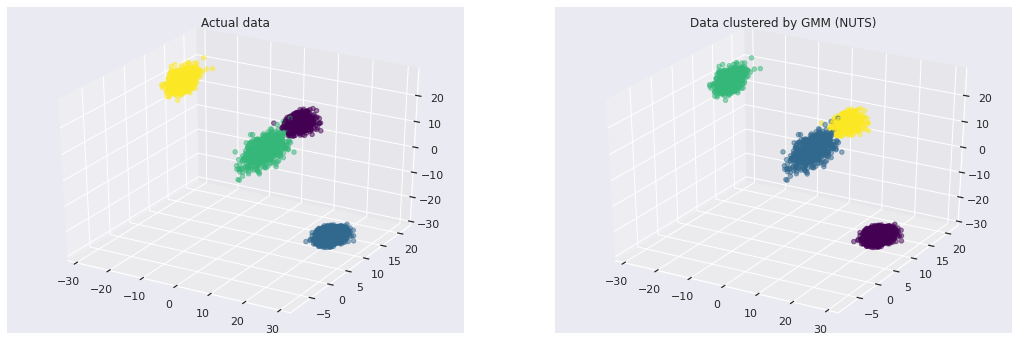

In [34]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(y_gmm[:,0], y_gmm[:,1], y_gmm[:,2], alpha=0.5, c = ind, cmap='viridis')
ax.set_title('Actual data')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(y_gmm[:,0], y_gmm[:,1], y_gmm[:,2], alpha=0.5, c = ind_samp, cmap='viridis')
ax.set_title('Data clustered by GMM (NUTS)')
plt.show()

In [35]:
rec_ind_samp = list()
y_samp = list()
for i in range(N):
    opt = np.random.choice(list(range(K)),p=theta_samp)
    rec_ind_samp.append(opt)
    y_samp.append(np.random.multivariate_normal(mu_samp[opt],np.diag(sigma_samp[opt])))
y_samp = np.array(y_samp)
rec_ind_samp = np.array(rec_ind_samp)

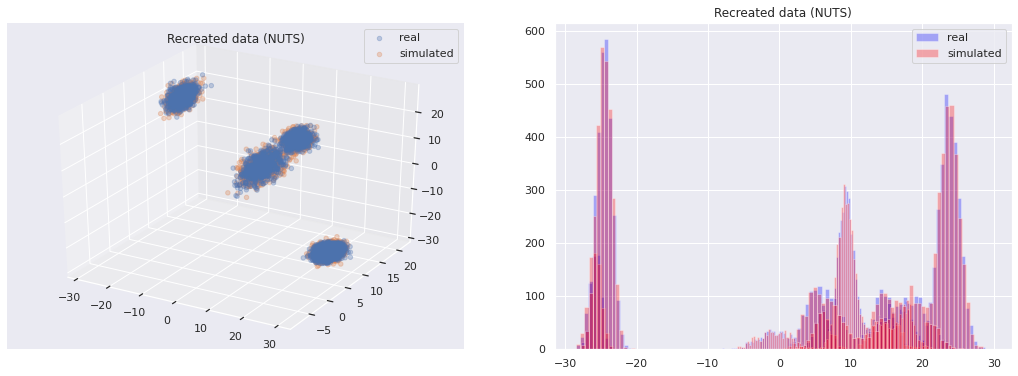

In [38]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_gmm[:,0], y_gmm[:,1], y_gmm[:,2], alpha=0.3, label='real')
ax.scatter(y_samp[:,0], y_samp[:,1], y_samp[:,2], alpha=0.3, label='simulated')
ax.set_title('Recreated data (NUTS)')
ax.legend()
plt.show()
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(131)
ax.hist(y_gmm[:,0], alpha=0.3, color='blue', label='real')
ax.hist(y_vb[:,0], alpha=0.3, color='red', label='simulated')
ax.legend()
ax = fig.add_subplot(132)
ax.hist(y_gmm[:,1], alpha=0.3, color='blue', label='real')
ax.hist(y_vb[:,1], alpha=0.3, color='red', label='simulated')
ax.legend()
ax = fig.add_subplot(133)
ax.hist(y_gmm[:,2], alpha=0.3, color='blue', label='real')
ax.hist(y_vb[:,2], alpha=0.3, color='red', label='simulated')
ax.legend()
ax.set_title('Recreated data (NUTS)')
plt.show()

### ADVI example
(Works due to 'normal_lpdf' instead of 'multi_normal_lpdf' with diagonal cov. matrix, fixed in own model)

In [71]:
advi_gmm_code = '''
data{
    int<lower=0> N;// number  of  data  points  in  entire  dataset
    int<lower=0> K;// number  of  mixture  components
    int<lower=0> D;//  dimension
    vector[D]  y [N];//  observations
    
    //real<lower=0> alpha0 ;  //  dirichlet  prior
}

//transformed  data{
//    vector<lower=0>[K]  alpha0_vec ;
//    for(k in 1:K)
//        alpha0_vec[k] = alpha0 ;
//}

parameters{
    simplex[K]  theta ;//  mixing  proportions
    vector[D] mu[K] ;//  locations  of  mixture  components
    vector<lower=0>[D]  sigma [K] ;   //  standard  deviations  of  mixture  components
}

model{
    //  priors
    //theta ~ dirichlet( alpha0_vec );
    for(k in 1:K)  {
        mu[k] ~ normal(0.0, 3.0);
        sigma[k] ~ lognormal(0.0, 1.0);
    }
    
    //  likelihood
    for(n in 1:N)  {
        real ps [K] ;
        for(k in 1:K)  {
            ps[k] = log(theta[k]) + normal_lpdf(y[n] | mu[k],  sigma [k]) ;
        }
        target += log_sum_exp(ps) ;
    }
}
'''

In [72]:
advi_gmm  = pystan.StanModel(model_code = advi_gmm_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_17f4ad0185c824dbdd9dac61209fb278 NOW.


In [73]:
advi_gmm_dat = {'N': N,'K': K, 'D':D, 'y':y_gmm}

VB

In [74]:
gmm_data = advi_gmm.vb(data=advi_gmm_dat, init=[{'mu':kmeans_init.cluster_centers_}])

In [75]:
gmm_df = pd.read_csv(gmm_data['args']['sample_file'].decode('ascii'), comment='#').dropna()
gmm_df_mean = gmm_df.mean()
best_sample = gmm_df.iloc[np.argmax(gmm_df['log_p__'][1:])+1]
mu_vb = np.reshape(np.array(gmm_df_mean[gmm_df_mean.index.str.startswith('mu')]),(D,K)).T
sigma_vb = np.reshape(np.array(gmm_df_mean[gmm_df_mean.index.str.startswith('sigma')]),(D,K)).T
theta_vb = np.array(gmm_df_mean[gmm_df_mean.index.str.startswith('theta')])
theta_vb = theta_vb/sum(theta_vb)

NUTS

In [37]:
gmm_data = advi_gmm.sampling(data=advi_gmm_dat, chains=1, iter=500, init=[{'mu':kmeans_init.cluster_centers_}])

In [40]:
theta_samp = np.mean(gmm_data['theta'],axis=0)
mu_samp = np.mean(gmm_data['mu'], axis=0)
sigma_samp = np.mean(gmm_data['sigma'], axis=0)

Results

In [ ]:
# fig = plt.figure(figsize=(18,6))
# ax = fig.add_subplot(121, projection='3d')
# ax.scatter(y_gmm[:,0], y_gmm[:,1], y_gmm[:,2], alpha=0.5, c = ind, cmap='viridis')
# ax.set_title('Actual data')
# ax = fig.add_subplot(122, projection='3d')
# ax.scatter(y_gmm[:,0], y_gmm[:,1], y_gmm[:,2], alpha=0.5, c = ind_vb, cmap='viridis')
# ax.scatter(mu_vb[:,0], mu_vb[:,1], mu_vb[:,2], alpha=0.5, c = 'red')
# ax.set_title('Data clustered by GMM (VB)')
# plt.show()


In [76]:
rec_ind_vb = list()
y_vb = list()
for i in range(N):
    opt = np.random.choice(list(range(K)),p=theta_vb)
    rec_ind_vb.append(opt)
    y_vb.append(np.random.multivariate_normal(mu_vb[opt],np.diag(sigma_vb[opt])))
y_vb = np.array(y_vb)
rec_ind_vb = np.array(rec_ind_vb)

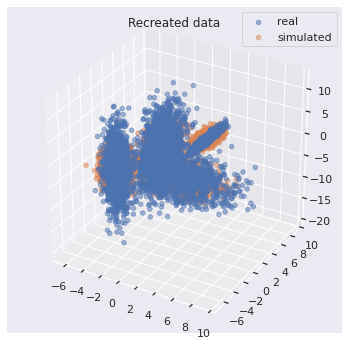

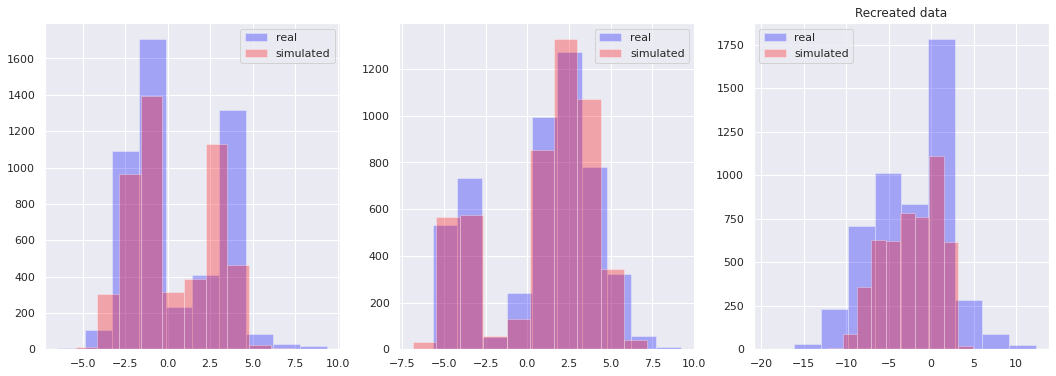

In [77]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_gmm[:,0], y_gmm[:,1], y_gmm[:,2], alpha=0.5, label='real')
ax.scatter(y_vb[:,0], y_vb[:,1], y_vb[:,2], alpha=0.5, label='simulated')#, c = rec_ind_vb, cmap='viridis')
ax.set_title('Recreated data')
ax.legend()
plt.show()
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(131)
ax.hist(y_gmm[:,0], alpha=0.3, color='blue', label='real')
ax.hist(y_vb[:,0], alpha=0.3, color='red', label='simulated')
ax.legend()
ax = fig.add_subplot(132)
ax.hist(y_gmm[:,1], alpha=0.3, color='blue', label='real')
ax.hist(y_vb[:,1], alpha=0.3, color='red', label='simulated')
ax.legend()
ax = fig.add_subplot(133)
ax.hist(y_gmm[:,2], alpha=0.3, color='blue', label='real')
ax.hist(y_vb[:,2], alpha=0.3, color='red', label='simulated')
ax.legend()
ax.set_title('Recreated data')
plt.show()


### MoPPCAs

In [63]:
moppcas_model = loadStan('moppcas', recompile=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_93c92cdbff3dab6c35c4d8ccfb446f6c NOW.


Model compiled succesfully.
Model saved succesfully to cache.


In [21]:
moppcas2 = loadStan('moppcas2', recompile=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f8adc8bc0d0bbf0f9698343477c25781 NOW.


Loading model  moppcas2
Model compiled succesfully.
Model saved succesfully to cache.


In [22]:
# pystan.StanModel(file='StanModels/moppcas2.stan')

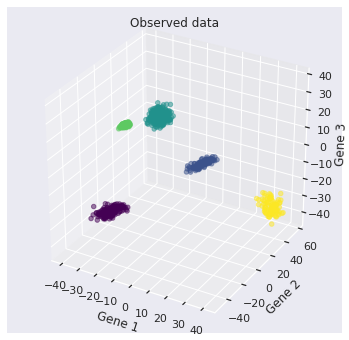

In [23]:
N=1000
M=2
D=3
K=5
mu = np.random.uniform(-50,50,size=(K,D))
sigma = np.random.uniform(0,3,size=(K))
while True:      # make sure to not have a negligible cluster
    theta = np.random.dirichlet(np.ones(K))
    if np.all(theta>(1.0/(2*K))):
        break

z = []
W = []
for k in range(K):
    W.append(np.random.normal(0,1.5,size=(D,M)))
    z.append(np.random.normal(0,1, size=(M,N)))
    
x = np.zeros((N,D))
ind = []
for n in range(N):
    opt = np.random.choice(list(range(K)),p=theta)
    x[n,:] = np.random.normal(np.matmul(W[opt],z[opt][:,n])+mu[opt], sigma[opt])
    ind.append(opt)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind, cmap='viridis', alpha=0.5)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

In [24]:
kmeans_init = KMeans(K).fit(x)
moppcas_dat = {'N': N, 'M': M, 'K': K, 'D':D, 'y':x}

NUTS

In [25]:
fit = moppcas2.sampling(data=moppcas_dat, chains=1, iter=500, init=[{'mu':kmeans_init.cluster_centers_,
                                                                     'theta':[sum(kmeans_init.labels_==k)/N for k in range(K)]}])
fit_ext = fit.extract()
best_ind = np.where(fit_ext['lp__']==max(fit_ext['lp__']))[0][0]

RuntimeError: Exception: variable does not exist; processing stage=data initialization; variable name=lim_sigma_up; base type=double  (in 'moppcas2.stan' at line 6)


In [388]:
theta_nuts = np.mean(fit['theta'],axis=0)
W_nuts = np.mean(fit['W'],axis=0)
z_nuts = fit['z'][best_ind]
mu_nuts = np.mean(fit['mu'],axis=0)
sigma_nuts = np.mean(fit['sigma'],axis=0)
ind_nuts = np.argmax(np.mean(fit['R'],axis=0),axis=1)

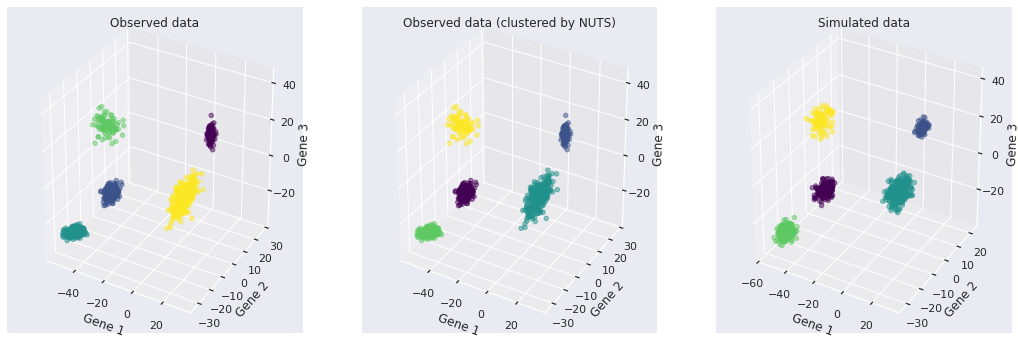

In [390]:
x_nuts_rec = np.zeros((N,D))
ind_nuts_rec = []
for n in range(N):
    opt = ind_nuts[n]
    x_nuts_rec[n,:] = np.random.normal(np.matmul(W_nuts[opt],z_nuts[n,:])+mu_nuts[opt], sigma_nuts[opt])
    ind_nuts_rec.append(opt)

fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind, cmap='viridis', alpha=0.5)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind_nuts, cmap='viridis', alpha=0.5)
ax.set_title('Observed data (clustered by NUTS)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(x_nuts_rec[:,0],x_nuts_rec[:,1],x_nuts_rec[:,2], c=ind_nuts_rec, cmap='viridis', alpha=0.5)
ax.set_title('Simulated data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

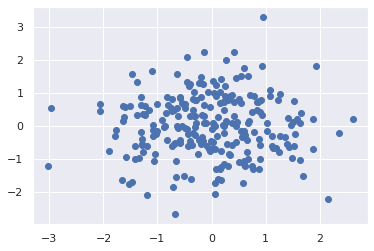

[0.95353752 0.92436518]


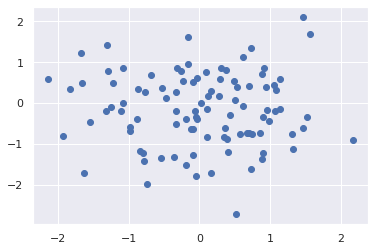

[0.90181901 0.89394064]


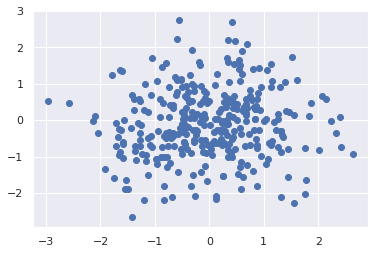

[0.96209938 0.95005571]


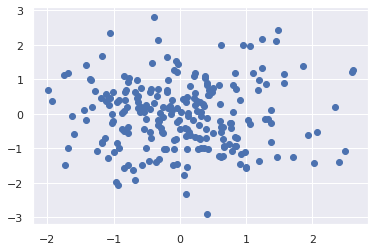

[0.90793509 0.97404977]


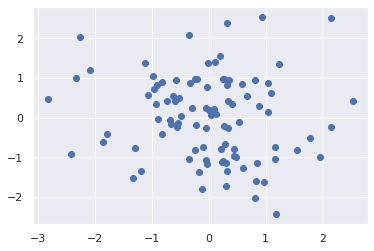

[1.00466877 1.05469522]


In [392]:
for k in range(K):
    plt.scatter(z_nuts[ind_nuts==k,0], z_nuts[ind_nuts==k,1])
    plt.show()
    print(np.std(z_nuts[ind_nuts==k,:],axis=0))

VB

In [26]:
kmeans_init = KMeans(K).fit(x)

In [22]:
moppcas2 = loadStan('moppcas2', recompile=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d794f1ddcba96624d6f4c596ac5c0bf2 NOW.


Loading model  moppcas2
Model compiled succesfully.
Model saved succesfully to cache.


In [27]:
moppcas_dat = {'N': N, 'M': M, 'K': K, 'D':D, 'y':x, 'lim_sigma_up':[np.max(np.std(x[kmeans_init.labels_==k],axis=0)) for k in range(K)],
              'lim_mu_up':[np.max(x[kmeans_init.labels_==k],axis=0) for k in range(K)],
              'lim_mu_low':[np.min(x[kmeans_init.labels_==k],axis=0) for k in range(K)]}

In [28]:
fit_vb = moppcas2.vb(data=moppcas_dat, init=[{'mu':kmeans_init.cluster_centers_,'theta':[sum(kmeans_init.labels_==k)/N for k in range(K)]}])

In [5]:
moppcas_w = loadStan('moppcas_weighted')

Loading model  moppcas_weighted
Model loaded succesfully from cache.


In [6]:
moppcas_dat = {'N': N, 'M': M, 'K': K, 'D':D, 'y':x, 'lim_sigma_up':[np.max(np.std(x[kmeans_init.labels_==k],axis=0)) for k in range(K)],
              'lim_mu_up':[np.max(x[kmeans_init.labels_==k],axis=0) for k in range(K)],
              'lim_mu_low':[np.min(x[kmeans_init.labels_==k],axis=0) for k in range(K)], 'weights':np.ones(N)}

In [7]:
fit_vb = moppcas_w.vb(data=moppcas_dat, init=[{'mu':kmeans_init.cluster_centers_,'theta':[sum(kmeans_init.labels_==k)/N for k in range(K)]}])

In [29]:
moppcas_df = pd.read_csv(fit_vb['args']['sample_file'].decode('ascii'), comment='#').dropna()
moppcas_df_mean = moppcas_df.mean()
best_sample = moppcas_df.iloc[np.argmax(moppcas_df['log_p__'][1:])+1]
mu_vb = np.reshape(np.array(moppcas_df_mean[moppcas_df_mean.index.str.startswith('mu')]),(D,K)).T
sigma_vb = np.array(moppcas_df_mean[moppcas_df_mean.index.str.startswith('sigma')])
# sigma_vb = np.reshape(np.array(moppcas_df_mean[moppcas_df_mean.index.str.startswith('sigma')]),(D,K)).T
theta_vb = np.array(moppcas_df_mean[moppcas_df_mean.index.str.startswith('theta')])
theta_vb = theta_vb/sum(theta_vb)
# z_vb = np.reshape(np.array(best_sample[moppcas_df_mean.index.str.startswith('z')]),(N,M,K)).T
z_vb = np.reshape(np.array(best_sample[moppcas_df_mean.index.str.startswith('z')]),(M,N))
W_vb = np.reshape(np.array(moppcas_df_mean[moppcas_df_mean.index.str.startswith('W')]),(M,D,K)).T
R_vb = np.reshape(np.array(moppcas_df_mean[moppcas_df_mean.index.str.startswith('R')]),(K,N)).T
ind_vb = np.argmax(R_vb, axis=1)

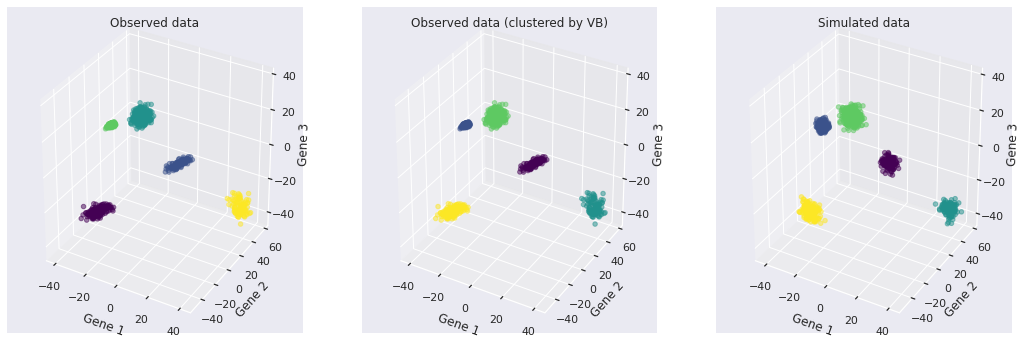

In [30]:
x_vb_rec = np.zeros((N,D))
ind_vb_rec = []
for n in range(N):
    opt = ind_vb[n]
    x_vb_rec[n,:] = np.random.normal(np.matmul(W_vb[opt],z_vb[:,n])+mu_vb[opt], sigma_vb[opt])
    ind_vb_rec.append(opt)

fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind, cmap='viridis', alpha=0.5)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind_vb, cmap='viridis', alpha=0.5)
# for i in [2,3,4]:
#     ax.scatter(mu_vb[i,0],mu_vb[i,1],mu_vb[i,2], c='red')
ax.set_title('Observed data (clustered by VB)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(x_vb_rec[:,0],x_vb_rec[:,1],x_vb_rec[:,2], c=ind_vb_rec, cmap='viridis', alpha=0.5)
ax.set_title('Simulated data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

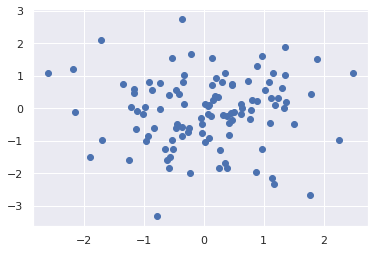

[0.97111504 1.07116128]


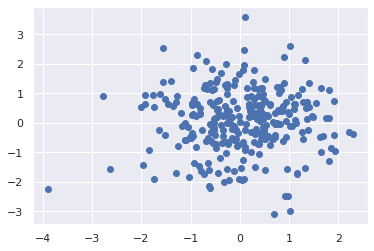

[0.93672387 1.03702762]


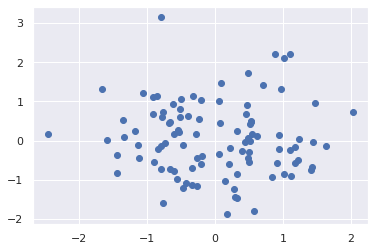

[0.86444773 0.92041497]


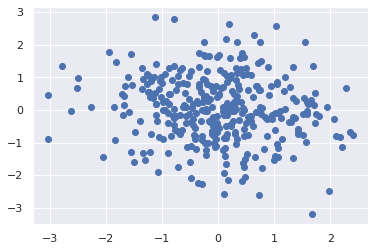

[0.98478961 1.00565126]


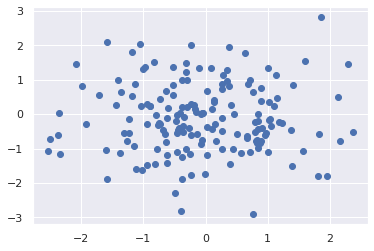

[1.01293817 1.00709397]


In [31]:
for k in range(K):
    plt.scatter(z_vb[0,ind_vb==k], z_vb[1,ind_vb==k])
    plt.show()
    print(np.std(z_vb[:,ind_vb==k],axis=1))

### Test MoPPCAs on splatter dataset

In [83]:
data, labels = pickle.load(open('smallsplat_prep_whole.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(500, 400)


In [121]:
K=5
M=2

In [84]:
order = np.argsort(-np.std(-data, axis=0))
data = data[:,order]

PPCA with VB works on full dimensional space:

In [102]:
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':data}
ppca_data = ppca_model.vb(data = ppca_dat)

In [103]:
ppca_df = pd.read_csv(ppca_data['args']['sample_file'].decode('ascii'), comment='#').dropna()
ppca_df_mean = ppca_df.mean()
best_sample_ppca = ppca_df.iloc[np.argmax(ppca_df['log_p__'][1:])+1]

In [111]:
latent_splatter = np.reshape(np.array(ppca_df_mean[ppca_df_mean.index.str.startswith('z')]),(N,M)).T

MoPPCAs also seems to work now!

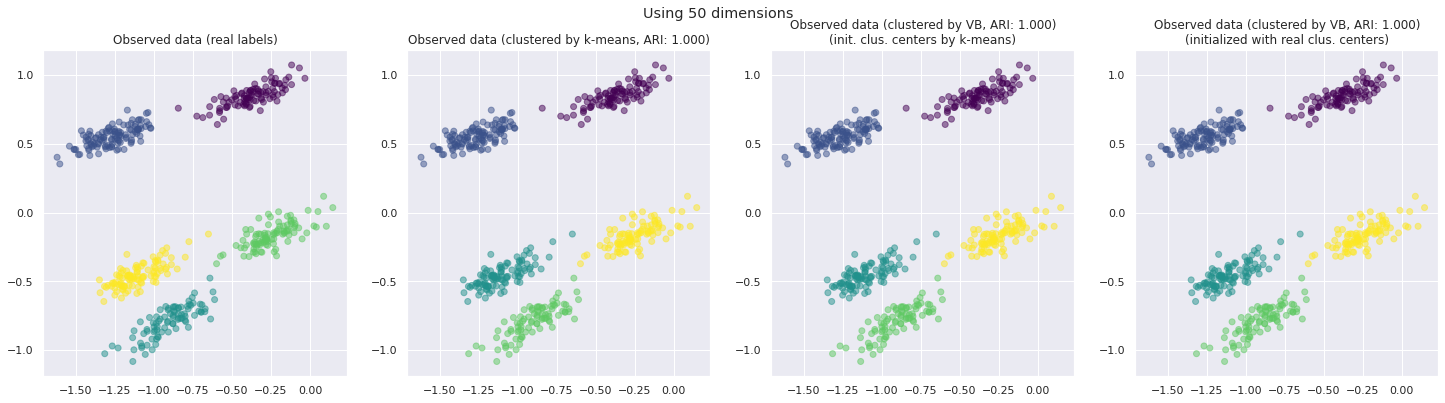

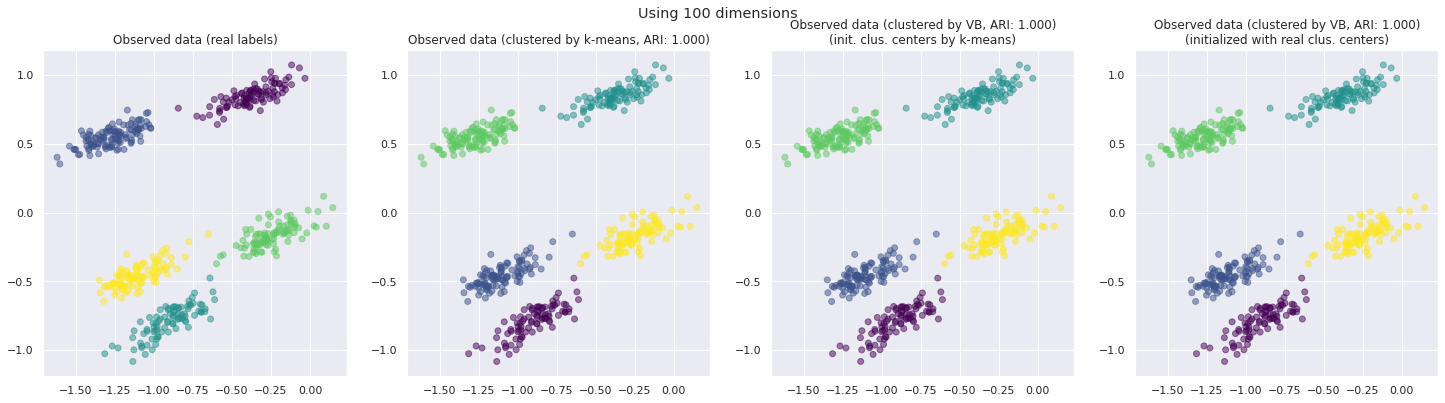

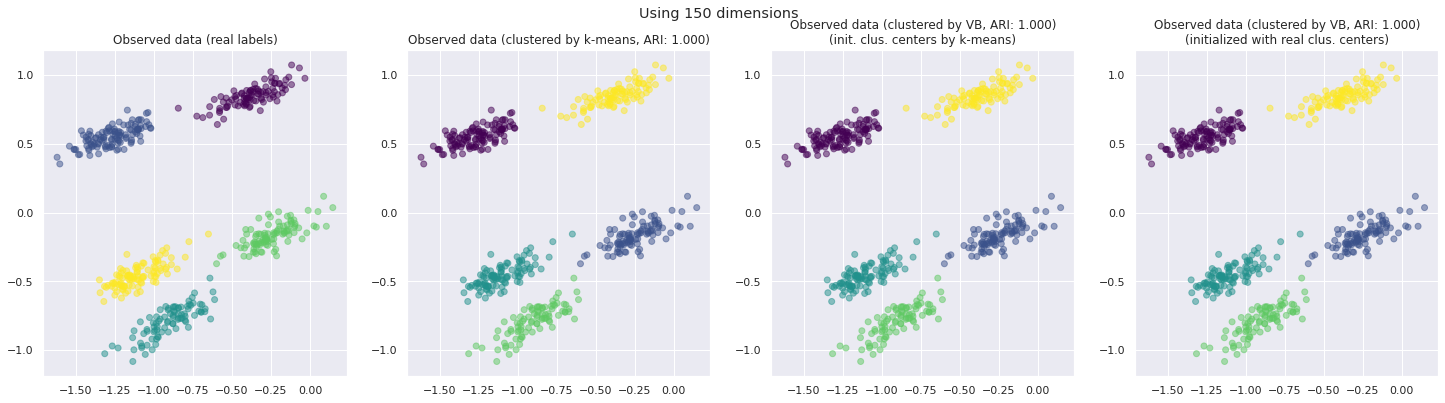

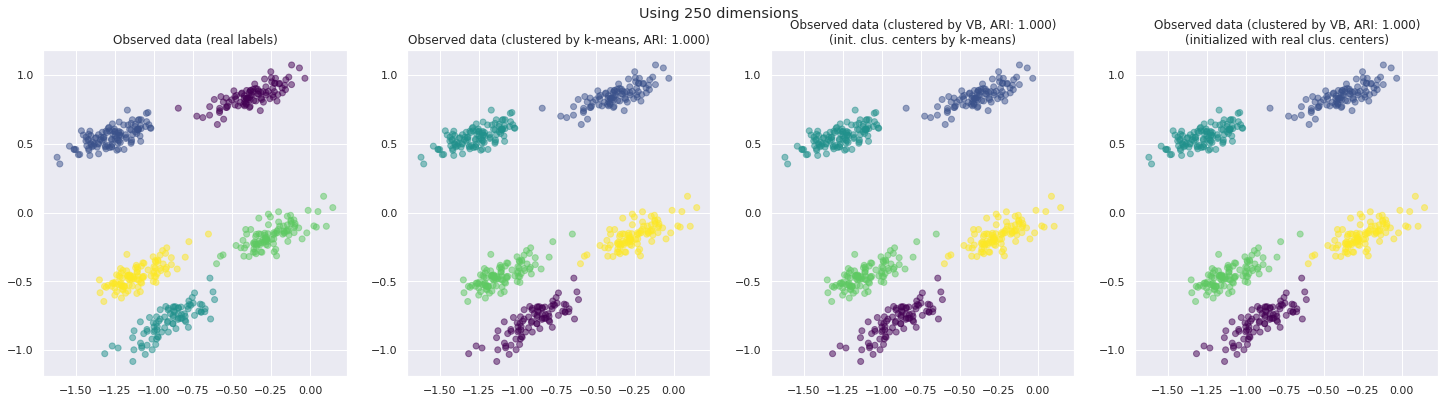

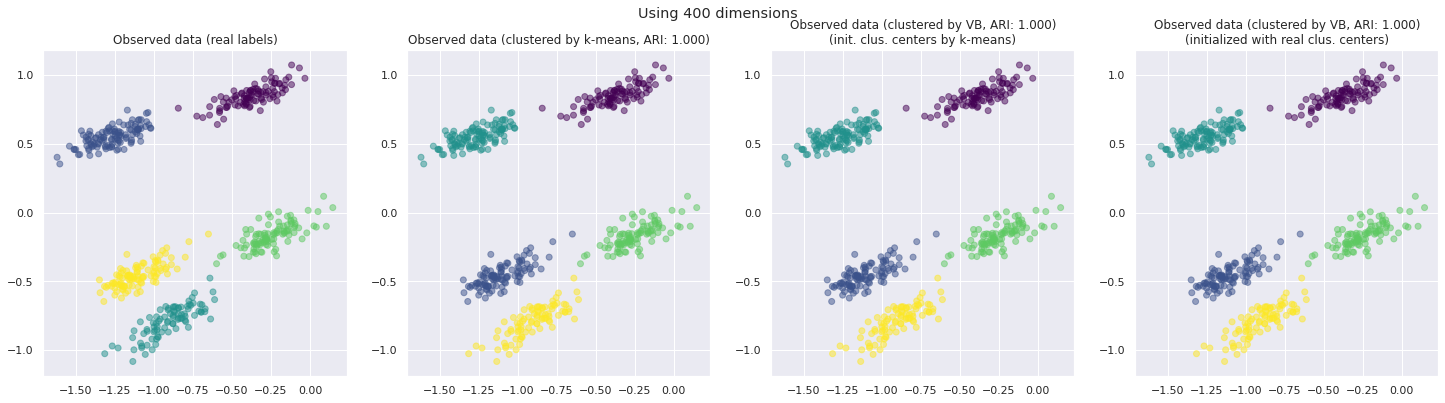

In [202]:
for D in [50, 100, 150, 250,400]:
    small_data = data[:,:D]

    kmeans_init = KMeans(K).fit(small_data)

    moppcas_dat = {'N': N, 'M': 2, 'K': K, 'D':D, 'y':small_data, 'lim_sigma_up':[1.2*np.max(np.std(small_data[kmeans_init.labels_==k],axis=0)) for k in range(K)],
                  'lim_mu_up':[np.max(small_data[kmeans_init.labels_==k],axis=0) for k in range(K)],
                  'lim_mu_low':[np.min(small_data[kmeans_init.labels_==k],axis=0) for k in range(K)], 'weights':np.ones(N)}
    fit_vb = moppcas2.vb(data=moppcas_dat, init=[{'mu':kmeans_init.cluster_centers_,'theta':[sum(kmeans_init.labels_==k)/N for k in range(K)],
                                                   'z':[np.zeros((2,N)) for k in range(D)]}])
    fit_vb2 = moppcas2.vb(data=moppcas_dat, init=[{'mu':[np.mean(small_data[labels==k,:],axis=0) for k in range(K)],'theta':[sum(kmeans_init.labels_==k)/N for k in range(K)],
                                                   'z':[np.zeros((2,N)) for k in range(D)]}])

    moppcas_df = pd.read_csv(fit_vb['args']['sample_file'].decode('ascii'), comment='#').dropna()
    moppcas_df_mean = moppcas_df.mean()
    R_vb = np.reshape(np.array(moppcas_df_mean[moppcas_df_mean.index.str.startswith('R')]),(K,N)).T
    ind_vb = np.argmax(R_vb, axis=1)
    
    moppcas_df2 = pd.read_csv(fit_vb2['args']['sample_file'].decode('ascii'), comment='#').dropna()
    moppcas_df_mean2 = moppcas_df2.mean()
    R_vb2 = np.reshape(np.array(moppcas_df_mean2[moppcas_df_mean2.index.str.startswith('R')]),(K,N)).T
    ind_vb2 = np.argmax(R_vb2, axis=1)

    fig = plt.figure(figsize=(25,6))
    plt.suptitle('Using %i dimensions'%D)
    ax = fig.add_subplot(1,4,1)
    ax.scatter(latent_splatter[0,:],latent_splatter[1,:], c=labels, cmap='viridis', alpha=0.5)
    ax.set_title('Observed data (real labels)')
    ax = fig.add_subplot(1,4,2)
    ax.scatter(latent_splatter[0,:],latent_splatter[1,:], c=kmeans_init.labels_, cmap='viridis', alpha=0.5)
    ax.set_title('Observed data (clustered by k-means, ARI: %.3f)'%(adjusted_rand_score(labels, kmeans_init.labels_)))
    ax = fig.add_subplot(1,4,3)
    ax.scatter(latent_splatter[0,:],latent_splatter[1,:], c=ind_vb, cmap='viridis', alpha=0.5)
    ax.set_title('Observed data (clustered by VB, ARI: %.3f)\n(init. clus. centers by k-means)'%(adjusted_rand_score(labels, ind_vb)))
    ax = fig.add_subplot(1,4,4)
    ax.scatter(latent_splatter[0,:],latent_splatter[1,:], c=ind_vb2, cmap='viridis', alpha=0.5)
    ax.set_title('Observed data (clustered by VB, ARI: %.3f)\n(initialized with real clus. centers)'%(adjusted_rand_score(labels, ind_vb2)))
    plt.show()